In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load dataset generated in Notebook 5
df = pd.read_pickle(INPUT_FILE)
print(f"Dataset loaded: {df.shape} rows")
print(f"Columns: {list(df.columns)}")

Dataset loaded: (74759, 26) rows
Columns: ['review_text', 'review_en', 'rating', 'date', 'user_total_reviews', 'user_id', 'is_local_guide', 'lang', 'park_name', 'text_length', 'year', 'month', 'quarter', 'month_name', 'season', 'gender', 'text_bert', 'text_stats', 'text_en_clean', 'topic_id', 'topic_label', 'sentiment_true', 'dataset_split', 'predicted_rating', 'final_sentiment', 'emotion']


### Temporal Evolution of Online Reviews

In [ ]:
import pandas as pd
import numpy as np

def generate_review_evolution_table(df_pivot: pd.DataFrame) -> pd.DataFrame:

    # Replace missing values with 0 and ensure integer counts
    review_counts = df_pivot.fillna(0).astype(int)

    # Year-over-year variation: current / previous * 100
    review_variation = (review_counts / review_counts.shift(1)) * 100

    final_df = pd.DataFrame(index=review_counts.index)
    park_names = review_counts.columns.tolist()

    for park in park_names:
        count_col = park
        variation_col = f"% Variation ({park})"

        # Annual review counts
        final_df[count_col] = review_counts[park]

        # Year-over-year variation
        variation_series = review_variation[park].copy()

        # Replace inf/NaN (first year or growth from zero) with NaN
        mask_invalid = np.isinf(variation_series) | pd.isna(variation_series)
        variation_series[mask_invalid] = np.nan

        final_df[variation_col] = variation_series

    return final_df.rename_axis("year")


# Pivot by year and park
df_pivot_real = df.groupby(["year", "park_name"]).size().unstack(fill_value=0)

# Generate evolution table
evolution_table = generate_review_evolution_table(df_pivot_real)

# Inspect table
display(evolution_table)

,Parque Atracciones Madrid,% Variation (Parque Atracciones Madrid),Parque Warner,% Variation (Parque Warner),PortAventura,% Variation (PortAventura)
year,,,,,,
2009,0,NaN,1,NaN,0,NaN
2011,1,NaN,2,200.000000,2,NaN
2012,8,800.000000,13,650.000000,9,450.000000
2013,211,2637.500000,152,1169.230769,21,233.333333
2014,52,24.644550,61,40.131579,44,209.523810
2015,42,80.769231,74,121.311475,149,338.636364
2016,491,1169.047619,605,817.567568,764,512.751678
2017,586,119.348269,1346,222.479339,2820,369.109948
2018,1741,297.098976,5085,377.786033,4186,148.439716


Analyzing seasonality on 41099 labeled reviews (noise excluded).


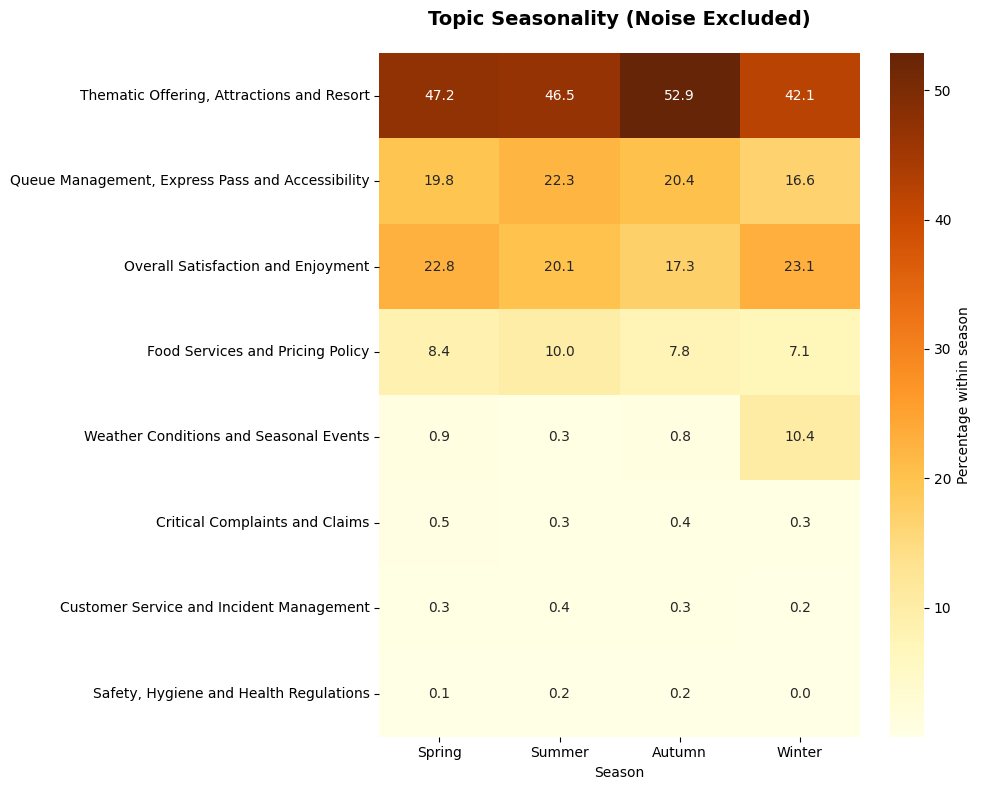

season,Spring,Summer,Autumn,Winter
topic_label,,,,
"Thematic Offering, Attractions and Resort",47.212131,46.499915,52.885494,42.125049
"Queue Management, Express Pass and Accessibility",19.823093,22.273782,20.360375,16.640285
Overall Satisfaction and Enjoyment,22.824198,20.072435,17.271444,23.149980
Food Services and Pricing Policy,8.434686,10.022070,7.797061,7.083498
Weather Conditions and Seasonal Events,0.868741,0.254655,0.780536,10.407598
Critical Complaints and Claims,0.458063,0.288608,0.415179,0.336367
Customer Service and Incident Management,0.284315,0.350857,0.282322,0.217649
"Safety, Hygiene and Health Regulations",0.094772,0.237678,0.207589,0.039573


In [ ]:
# 1. Filter out the "Other / Uncategorized" topic
df_clean_topics = df[df["topic_label"] != "Other / Uncategorized"]

print(f"Analyzing seasonality on {len(df_clean_topics)} labeled reviews (noise excluded).")

# 2. Topic–season crosstab (columns normalized to 100%)
season_topic_table = pd.crosstab(
    df_clean_topics["topic_label"],
    df_clean_topics["season"],
    normalize="columns"
) * 100

# 3. Order rows by topic_id and columns by season
season_order = ["Spring", "Summer", "Autumn", "Winter"]

topic_order = (
    df_clean_topics.groupby("topic_label")["topic_id"]
    .min()
    .sort_values()
    .index
)

season_topic_table = season_topic_table.loc[topic_order, season_order]

# 4. Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    season_topic_table,
    annot=True,
    fmt=".1f",
    cmap="YlOrBr",
    cbar_kws={"label": "Percentage within season"}
)

plt.title("Topic Seasonality (Noise Excluded)", fontsize=14, fontweight="bold", pad=20)
plt.ylabel("")
plt.xlabel("Season")
plt.tight_layout()
plt.show()

display(season_topic_table)

### Topic Modeling Results (BERTopic)

In [ ]:
import pandas as pd

# 1. Filtering: remove noise topics and create a clean dataframe
df_topics_clean = df[df['topic_id'] != -1].copy()

print(f"Reviews analyzed after noise removal: {len(df_topics_clean)}")

# 2. Aggregation: count topic frequencies
topics_df = df_topics_clean.groupby(['topic_id', 'topic_label']).size().reset_index(name='Frequency')

# 3. Sorting and computing percentages
topics_df = topics_df.sort_values('Frequency', ascending=False)
total_clean = topics_df['Frequency'].sum()
topics_df['% of Total'] = (topics_df['Frequency'] / total_clean * 100).round(2)

# 4. Topic-label cleaning (remove numeric prefixes)
def clean_topic_label(label):
    # Remove numeric prefix and keep semantic tokens
    try:
        parts = label.split('_')
        if parts[0].isdigit() or (parts[0].startswith('-') and parts[0][1:].isdigit()):
            return ", ".join(parts[1:])
        return label
    except:
        return label

topics_df['Keywords'] = topics_df['topic_label'].apply(clean_topic_label)

# 5. Final selection (e.g., top 8 topics)
final_topics_table = topics_df.head(8)[['Keywords', 'Frequency', '% of Total']]

print("\n--- MAIN TOPIC TABLE (Excluding 'Other') ---")
display(final_topics_table)

Reviews analyzed after noise removal: 41099

--- MAIN TOPIC TABLE (Excluding 'Other') ---


,Keywords,Frequency,% of Total
0,"Thematic Offering, Attractions and Resort",19704,47.94
1,"Queue Management, Express Pass and Accessibility",8484,20.64
2,Overall Satisfaction and Enjoyment,8242,20.05
3,Food Services and Pricing Policy,3602,8.76
4,Weather Conditions and Seasonal Events,720,1.75
5,Critical Complaints and Claims,147,0.36
6,Customer Service and Incident Management,125,0.30
7,"Safety, Hygiene and Health Regulations",75,0.18


In [ ]:
import matplotlib.pyplot as plt
import os

def plot_keywords_topic(results, n_top=10, filename="minimalist_figure_no_gridlines.pdf"):
    """
    Generate a clean 4x2 vertical figure for the top topics in `results`.
    """

    # Determine number of topics to plot (maximum 8)
    n_topics_to_plot = min(len(results), 8)

    n_rows = 4
    n_cols = 2

    # figsize=(11, 15) fits well on vertical A4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(11, 15))

    # White background
    fig.patch.set_facecolor('white')

    bar_color = '#595959'  # Anthracite gray
    axes = axes.flatten()

    print(f"Generating minimalist (no-grid) plot for the first {n_topics_to_plot} topics...")

    # Preserve ordering of topic IDs via results.items()
    for i, (topic, keywords_list) in enumerate(results.items()):
        # Stop once 8 subplots are filled
        if i >= n_topics_to_plot:
            break
        ax = axes[i]

        # 1. Prepare data
        keywords_top = keywords_list[:n_top]
        words = [item[0].replace('_', ' ') for item in keywords_top]
        scores = [item[1] for item in keywords_top]

        words.reverse()
        scores.reverse()
        max_score = max(scores) if scores else 0.1

        # 2. Draw bars
        ax.barh(words, scores, color=bar_color, height=0.65)

        # 3. Subplot title (i + 1 is a 1-based index)
        # Topic label is assumed to be pre-mapped
        ax.set_title(
            f'{i + 1}. {topic}',
            fontsize=12,
            fontweight='bold',
            loc='left',
            pad=12,
            color='#333333'
        )

        # 4. Add score labels
        for j, score in enumerate(scores):
            ax.text(
                score + (max_score * 0.02),
                j,
                f'{score:.3f}',
                va='center',
                color='#555555',
                fontsize=9
            )

        # 5. Minimalist style
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color('#CCCCCC')
        ax.spines['bottom'].set_linewidth(0.8)
        ax.tick_params(axis='y', length=0)

        # 6. X-axis configuration
        # Show full x-axis only on the last row
        if i >= n_rows * n_cols - n_cols:
            ax.set_xlabel('c-TF-IDF Score', fontsize=10, color='#555555', labelpad=10)
            ax.tick_params(axis='x', colors='#555555')
        else:
            ax.set_xticks([])
            ax.spines['bottom'].set_visible(False)

        ax.set_xlim(0, max_score * 1.3)

        # 7. Y-axis labels
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words, fontsize=10, color='#333333')

    # Global title
    fig.suptitle(
        'Dominant Keywords per Topic',
        fontsize=16,
        fontweight='bold',
        color='#333333',
        y=0.98
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


TOPIC_LABEL_TO_ID_MAP = (
    df[df['topic_id'] != -1]
    [['topic_id', 'topic_label']]
    .drop_duplicates()
    .sort_values('topic_id')
    .set_index('topic_label')['topic_id']
    .to_dict()
)

def get_top_keywords_by_topic(
    df,
    text_column='text_preprocessed',
    topic_column='topic_label',
    n_top=10,
    plot_grid=True
):

    print("\nComputing topic-level TF-IDF (preprocessed text)...")

    # --- TF-IDF computation ---
    df_corpus = (
        df.groupby(topic_column)[text_column]
        .apply(lambda x: ' '.join(x.astype(str)))
        .reset_index()
    )

    # Exclude "Other / Unclassified" topic
    df_corpus = df_corpus[
        df_corpus[topic_column] != 'Other / Unclassified'
    ].reset_index(drop=True)

    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=1,
        max_df=0.85,
        stop_words=None
    )

    tfidf_matrix = vectorizer.fit_transform(df_corpus[text_column])
    feature_names = vectorizer.get_feature_names_out()

    results = {}

    for i, topic in enumerate(df_corpus[topic_column]):
        feature_scores = tfidf_matrix[i, :].toarray().flatten()
        top_indices = feature_scores.argsort()[-n_top:][::-1]
        top_keywords = [
            (feature_names[j], feature_scores[j]) for j in top_indices
        ]
        # Store raw results; ordering will be enforced later via topic ID
        results[topic] = top_keywords

    print("\n--- Keywords per topic (TF-IDF) ---")

    data_for_df = []

    for topic_label, keywords in results.items():
        topic_id = TOPIC_LABEL_TO_ID_MAP.get(topic_label, 999)
        row = [topic_id, topic_label] + keywords
        data_for_df.append(row)

    column_names = ['Topic ID', 'Topic Label'] + list(range(n_top))
    df_results = pd.DataFrame(data_for_df, columns=column_names)

    # Sort by numeric topic ID
    df_results = df_results.sort_values(
        by='Topic ID',
        ascending=True
    ).reset_index(drop=True)

    # Format display: topic label as index, keyword (score)
    df_display = df_results.drop(columns=['Topic ID'])
    df_display = df_display.set_index('Topic Label')

    df_display = df_display.applymap(
        lambda x: f"{x[0]} ({x[1]:.3f})" if isinstance(x, tuple) else x
    )

    display(df_display)

    # Sort results dict by numeric topic ID to align with plotting
    def final_sort_key(topic_name):
        return TOPIC_LABEL_TO_ID_MAP.get(topic_name, 999)

    sorted_topics = sorted(results.keys(), key=final_sort_key)
    results_ordered = {topic: results[topic] for topic in sorted_topics}

    if plot_grid:
        plot_keywords_topic(results_ordered, n_top=n_top)

    return results_ordered


Computing topic-level TF-IDF (preprocessed text)...

--- Keywords per topic (TF-IDF) ---


/tmp/ipython-input-803072671.py:85: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_display = df_display.applymap(


,0,1,2,3,4,5,6,7,8,9
Topic Label,,,,,,,,,,
"Thematic Offering, Attractions and Resort",halloween (0.306),ferrari (0.229),land (0.191),ferrari land (0.180),españa (0.170),rusas (0.167),montañas (0.167),attente (0.167),montañas rusas (0.164),super (0.132)
"Queue Management, Express Pass and Accessibility",pass (0.260),attente (0.220),discapacidad (0.217),pase express (0.185),baños (0.177),pass express (0.158),trop (0.113),vergüenza (0.100),attraction (0.096),igual (0.085)
Overall Satisfaction and Enjoyment,pasar día (0.426),día familia (0.232),ideal (0.226),super (0.190),perfecto (0.189),familia amigos (0.167),peques (0.154),adrenalina (0.149),toda familia (0.143),adultos (0.128)
Food Services and Pricing Policy,comida bebida (0.271),bebidas (0.244),llevar (0.165),comidas (0.160),restaurante (0.126),comida cara (0.125),caros (0.122),llevar comida (0.117),botella (0.115),pasar comida (0.101)
Weather Conditions and Seasonal Events,navidad (0.667),navideña (0.197),decoración (0.189),invierno (0.146),lluvia (0.145),nadal (0.137),bonito (0.119),decoración navideña (0.100),diciembre (0.093),precioso (0.082)
Critical Complaints and Claims,vergüenza (0.078),super (0.069),atraccion (0.069),verguenza (0.061),españa (0.058),telefóno (0.055),discapacidad (0.048),columpio (0.047),puedo (0.043),sacar (0.043)
Customer Service and Incident Management,teléfono (0.271),atención cliente (0.186),correo (0.137),contactar (0.129),mail (0.121),factura (0.108),respuesta (0.105),vergüenza (0.093),código (0.079),reserva (0.071)
"Safety, Hygiene and Health Regulations",medidas covid (0.186),medidas seguridad (0.169),seguridad covid (0.169),tema covid (0.118),frente covid (0.105),buenas medidas (0.105),desinfección (0.094),debido covid (0.094),controlado (0.085),frente (0.085)
Other / Uncategorized,attente (0.192),pass (0.152),super (0.138),pasar día (0.121),calor (0.115),attraction (0.108),adultos (0.106),peques (0.091),temps (0.091),trop (0.090)


Generating minimalist (no-grid) plot for the first 8 topics...


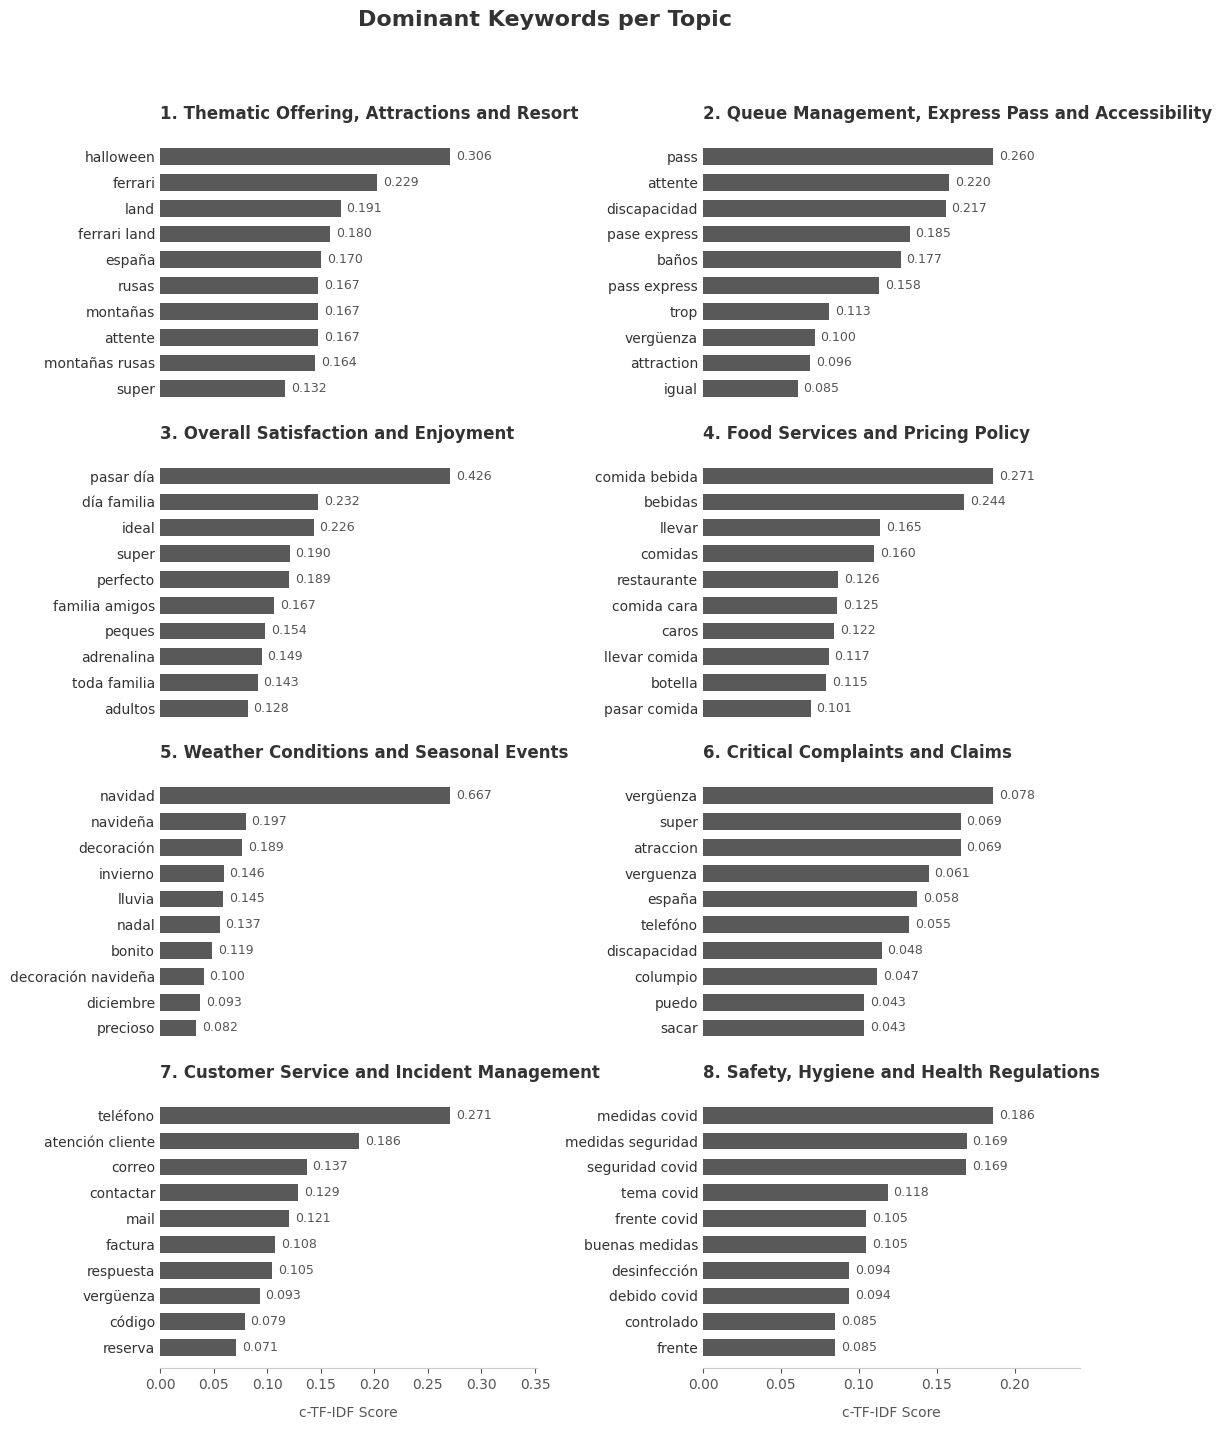

In [ ]:
results = get_top_keywords_by_topic(
    df,
    text_column='text_stats',
    topic_column='topic_label',
    n_top=10,
)

### Sentiment Analysis and Consistency with Star Ratings


--- Sentiment Distribution Table (%) ---


final_sentiment,negative,neutral,positive
park_name,,,
Parque Atracciones Madrid,17.62,18.30,64.08
Parque Warner,14.48,18.11,67.41
PortAventura,22.98,14.39,62.63


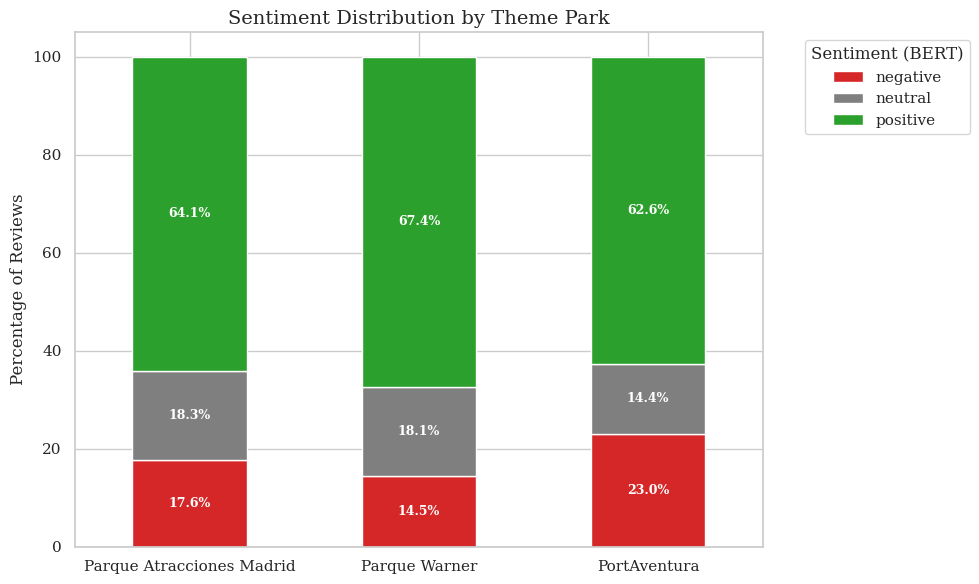

In [ ]:
# Aesthetic configuration
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'serif'

# --- SENTIMENT TABLE BY PARK ---
# Compute row-normalized sentiment percentages
sentiment_table = pd.crosstab(
    df['park_name'],
    df['final_sentiment'],
    normalize='index'
) * 100
sentiment_table = sentiment_table.round(2)

print("--- Sentiment Distribution Table (%) ---")
display(sentiment_table)

# --- VISUALIZATION (STACKED BAR CHART) ---
ax = sentiment_table.plot(
    kind='bar',
    stacked=True,
    color=['#d62728', '#7f7f7f', '#2ca02c'],
    figsize=(10, 6)
)

plt.title('Sentiment Distribution by Theme Park', fontsize=14)
plt.ylabel('Percentage of Reviews')
plt.xlabel('')
plt.legend(title='Sentiment (BERT)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Add in-bar percentage labels
for c in ax.containers:
    ax.bar_label(
        c,
        fmt='%.1f%%',
        label_type='center',
        color='white',
        fontsize=9,
        weight='bold'
    )

plt.tight_layout()
plt.show()


In [ ]:
# Assess alignment between star ratings and inferred sentiment
print("\n--- CONSISTENCY MATRIX (Star Ratings vs. BERT Sentiment) ---")

# Row-normalized cross-tabulation of ratings vs. sentiment
consistency_table = pd.crosstab(
    df["rating"],
    df["final_sentiment"],
    normalize="index"
) * 100

# Enforce consistent sentiment order
sentiment_order = ["negative", "neutral", "positive"]
consistency_table = consistency_table[sentiment_order]

# Rename columns for clarity
consistency_table.columns = [
    "Negative (BERT) %",
    "Neutral (BERT) %",
    "Positive (BERT) %"
]
consistency_table.index.name = "Google Rating"

display(consistency_table.round(2))



--- CONSISTENCY MATRIX (Star Ratings vs. BERT Sentiment) ---


,Negative (BERT) %,Neutral (BERT) %,Positive (BERT) %
Google Rating,,,
1,85.49,12.46,2.05
2,54.62,39.80,5.58
3,14.87,55.20,29.92
4,1.43,12.41,86.16
5,0.48,1.43,98.09


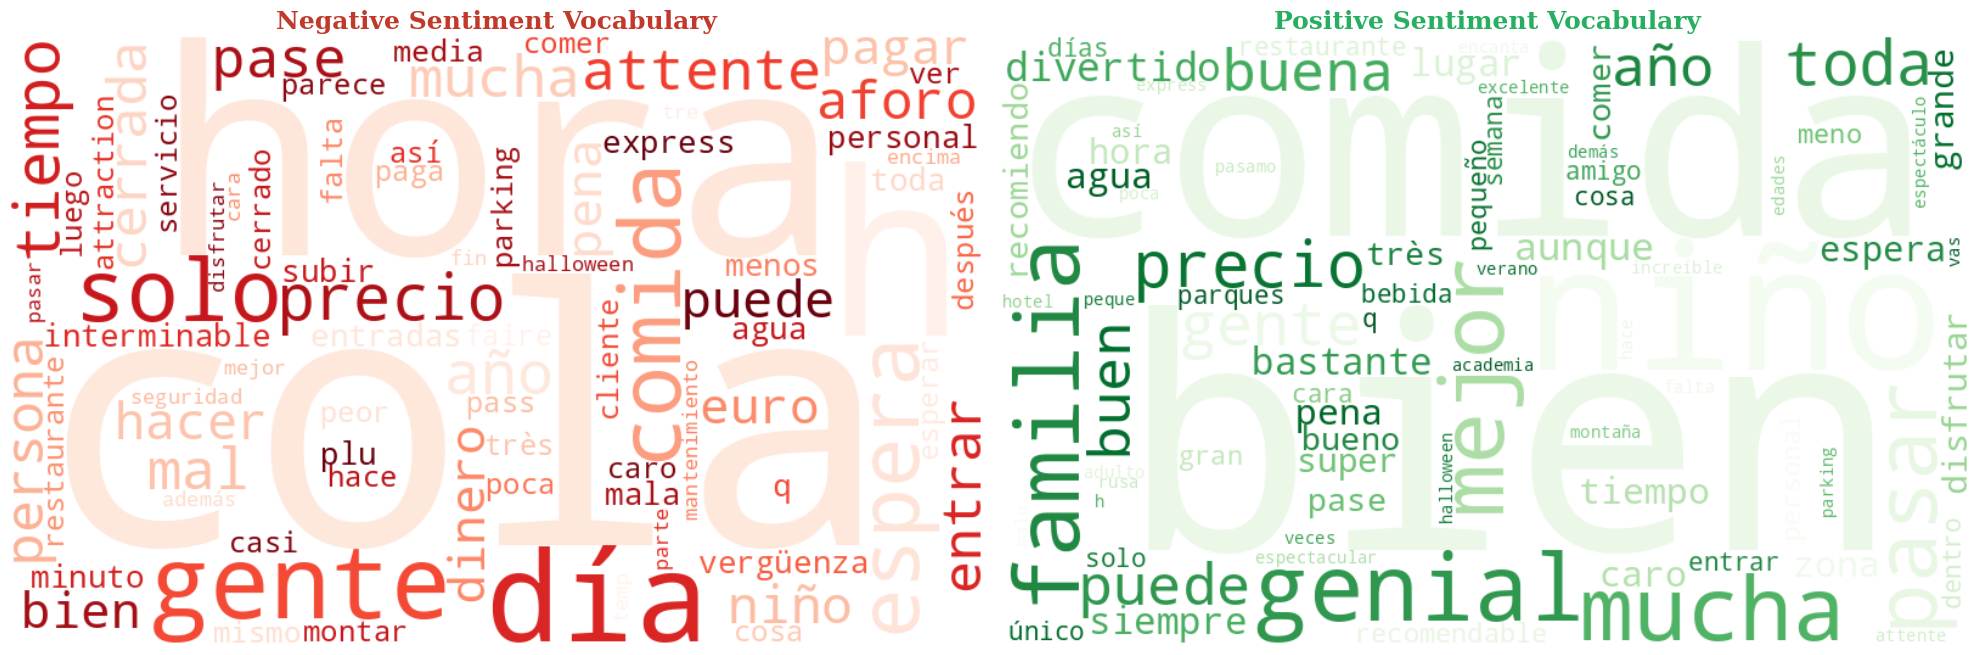

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# =========================================================
# Word clouds by sentiment
# =========================================================

# 1. Concatenate cleaned text by sentiment
text_positive = " ".join(
    df[df["final_sentiment"] == "positive"]["text_stats"].astype(str)
)
text_negative = " ".join(
    df[df["final_sentiment"] == "negative"]["text_stats"].astype(str)
)

# 2. Base stopwords + sentiment-specific adjustments
stopwords_neg = set(STOPWORDS)
stopwords_pos = set(STOPWORDS)
stopwords_pos.update([
    "cola", "colas", "hacer", "parque", "día", "ir", "ver"
])

# 3. Helper function for word cloud generation
def generate_wordcloud(text, color_map, stopwords_set):
    wc = WordCloud(
        background_color="white",
        max_words=80,
        width=800,
        height=500,
        colormap=color_map,
        stopwords=stopwords_set,
        collocations=False,
        random_state=42
    ).generate(text)
    return wc

# 4. Plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Negative sentiment
axes[0].imshow(
    generate_wordcloud(text_negative, "Reds", stopwords_neg),
    interpolation="bilinear"
)
axes[0].set_title(
    "Negative Sentiment Vocabulary",
    fontsize=18,
    fontweight="bold",
    color="#c0392b"
)
axes[0].axis("off")

# Positive sentiment
axes[1].imshow(
    generate_wordcloud(text_positive, "Greens", stopwords_pos),
    interpolation="bilinear"
)
axes[1].set_title(
    "Positive Sentiment Vocabulary",
    fontsize=18,
    fontweight="bold",
    color="#27ae60"
)
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def sentiment_by_gender_and_park(df: pd.DataFrame) -> pd.DataFrame:

    # Row-normalized crosstab: (park, gender) x sentiment (%)
    sentiment_table = pd.crosstab(
        [df['park_name'], df['gender']],
        df['final_sentiment'],
        normalize='index'
    ) * 100

    # Optional: enforce sentiment ordering
    sentiment_order = ['negative', 'neutral', 'positive']
    sentiment_table = sentiment_table.reindex(columns=sentiment_order)

    # Round for readability
    sentiment_table = sentiment_table.round(2)

    return sentiment_table

sentiment_gender_park_table = sentiment_by_gender_and_park(df)

print("Sentiment distribution (%) by gender and park")
display(sentiment_gender_park_table)


Sentiment distribution (%) by gender and park


final_sentiment                    negative  neutral  positive
park_name                 gender                              
Parque Atracciones Madrid female      17.79    18.46     63.75
                          male        16.64    18.08     65.29
                          unknown     19.53    18.54     61.93
Parque Warner             female      14.55    17.14     68.31
                          male        14.39    18.73     66.88
                          unknown     14.58    18.17     67.24
PortAventura              female      22.68    14.64     62.68
                          male        23.90    14.68     61.41
                          unknown     21.61    13.47     64.92

### Emotional Analysis Results

In [ ]:
# Build the cross-tabulation (Crosstab)
emotion_table = pd.crosstab(
    df['park_name'],
    df['emotion'],
    normalize='index'
) * 100

# Column ordering for interpretability
logical_order = [
    'excitement', 'joy', 'trust', 'anticipation',
    'boredom', 'frustration', 'mistrust', 'disgust', 'anger'
]

# Keep only emotions present in the dataset
final_cols = [c for c in logical_order if c in emotion_table.columns]
emotion_table = emotion_table[final_cols]

# Display
print("\n--- EMOTIONAL PROFILE BY PARK (%) ---")
display(emotion_table.round(2))


--- EMOTIONAL PROFILE BY PARK (%) ---


emotion,excitement,joy,boredom,frustration,mistrust,disgust,anger
park_name,,,,,,,
Parque Atracciones Madrid,40.77,18.19,0.65,32.05,3.93,4.27,0.13
Parque Warner,40.17,18.65,0.66,32.93,3.61,3.92,0.07
PortAventura,40.71,13.04,0.49,37.56,3.58,4.47,0.16


In [ ]:
# Crosstab: topic × emotion (%)
topic_emotion = pd.crosstab(
    df['topic_label'],
    df['emotion'],
    normalize='index'
) * 100

# Remove noise topic if present
if "Other / Unclassified" in topic_emotion.index:
    topic_emotion = topic_emotion.drop("Other / Unclassified")

# Order emotion columns
order_cols = [
    'excitement', 'joy', 'trust', 'anticipation',
    'boredom', 'frustration', 'mistrust', 'disgust', 'anger'
]
existing_cols = [c for c in order_cols if c in topic_emotion.columns]
topic_emotion = topic_emotion[existing_cols]

# Sort topics by numeric ID
topic_emotion = topic_emotion.sort_index(
    key=lambda idx: [TOPIC_LABEL_TO_ID_MAP.get(i, 999) for i in idx]
)

display(topic_emotion.round(1))

emotion,excitement,joy,boredom,frustration,mistrust,disgust,anger
topic_label,,,,,,,
"Thematic Offering, Attractions and Resort",46.4,16.1,0.3,30.5,3.0,3.5,0.1
"Queue Management, Express Pass and Accessibility",27.1,6.4,1.0,54.3,4.7,6.4,0.1
Overall Satisfaction and Enjoyment,55.3,36.9,0.6,4.5,1.5,1.1,0.1
Food Services and Pricing Policy,26.4,13.0,0.5,46.9,5.4,7.7,0.1
Weather Conditions and Seasonal Events,42.1,25.6,0.8,27.5,2.5,1.5,0.0
Critical Complaints and Claims,36.7,6.1,0.0,45.6,4.8,6.1,0.7
Customer Service and Incident Management,3.2,2.4,0.0,79.2,8.0,7.2,0.0
"Safety, Hygiene and Health Regulations",44.0,22.7,1.3,22.7,8.0,1.3,0.0
Other / Uncategorized,38.5,13.4,0.6,38.8,4.1,4.5,0.1


### Cross-Park Mention Analysis


Detecting cross-park mentions in review text...

--- CROSS-PARK MENTION MATRIX (% of reviews mentioning a competitor) ---


,PortAventura,Parque Warner,Parque Atracciones Madrid
park_name,,,
Parque Atracciones Madrid,0.50,4.45,0.00
Parque Warner,1.65,0.00,0.70
PortAventura,0.00,0.49,0.08


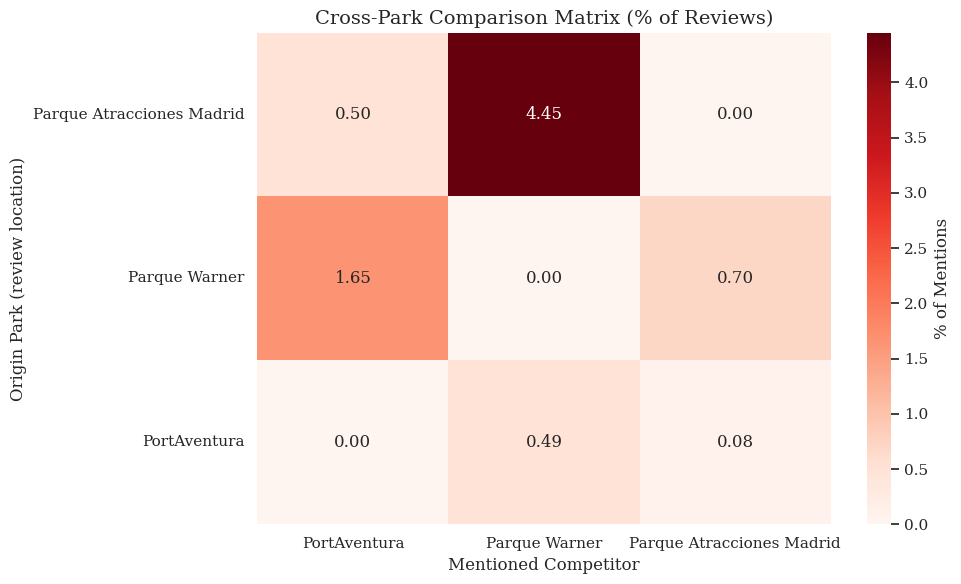

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Canonical park names and alias patterns
park_aliases = {
    "PortAventura": [
        # Name variations
        "portaventura", "port aventura", "ferrari land", "ferrariland", " pa ",
        # Location references
        "salou", "vila-seca", "tarragona",
        # Signature attractions
        "shambhala", "dragon khan", "furius baco", "red force", "sesamo aventura"
    ],
    "Parque Warner": [
        # Name variations
        "warner", "parque warner", "la warner", "warner beach",
        # Location references
        "san martín de la vega", "san martin",
        # Signature attractions
        "stunt fall", "superman", "batman", "coaster express",
        "gotham", "academia policia", "academia polícia", "correcaminos"
    ],
    "Parque Atracciones Madrid": [
        # Name variations
        "parque de atracciones de madrid", "el de madrid", "el del batán", "el del batan",
        "parque atracciones madrid", "parque de atracciones madrid",
        "el parque de las atracciones de madrid",
        "el parque de la casa de campo", "el de casa de campo",
        # Acronym with padding to reduce false positives
        " pam ",
        # Location references
        "casa de campo", "batan", "batán",
        # Signature attractions
        "abismo", "tarántula", "tarantula", "la lanzadera", "star flyer", "tornado"
    ]
}

# 1. Detect cross-park mentions in review text
df_cross = df.copy()

print("Detecting cross-park mentions in review text...")
for park, keywords in park_aliases.items():
    df_cross[park] = df_cross["text_bert"].apply(
        lambda x: 1 if pd.notna(x) and any(k in str(x).lower() for k in keywords) else 0
    )

# 2. Compute percentages by origin park
total_reviews_by_park = df_cross["park_name"].value_counts()
mentions_count = df_cross.groupby("park_name")[list(park_aliases.keys())].sum()
percentage_table = mentions_count.div(total_reviews_by_park, axis=0) * 100

# 3. Remove self-mentions from the diagonal
for p in park_aliases.keys():
    if p in percentage_table.index:
        percentage_table.loc[p, p] = 0

percentage_table = percentage_table.round(2)

print("\n--- CROSS-PARK MENTION MATRIX (% of reviews mentioning a competitor) ---")
display(percentage_table)

# 4. Visualization: cross-park comparison heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    percentage_table,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    cbar_kws={"label": "% of Mentions"}
)
plt.title("Cross-Park Comparison Matrix (% of Reviews)", fontsize=14)
plt.ylabel("Origin Park (review location)")
plt.xlabel("Mentioned Competitor")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# 1. Define origin–destination park pairs using canonical names
comparison_pairs = [
    ("Parque Atracciones Madrid", "Parque Warner"),
    ("Parque Warner", "Parque Atracciones Madrid"),
    ("Parque Warner", "PortAventura"),
    ("PortAventura", "Parque Warner")
]

# Short labels for table columns
park_short_names = {
    "Parque Atracciones Madrid": "PAM",
    "Parque Warner": "PW",
    "PortAventura": "PA"
}

# Container for topic distributions per comparison
topic_results = {}

# Remove noise topics (topic_id = -1)
df_clean = df[df["topic_id"] != -1].copy()

print("Building topic profile for cross-park comparisons...\n")

for origin, target in comparison_pairs:
    # 1. Filter reviews mentioning the target park
    keywords = park_aliases[target]

    mention_mask = df_clean["text_bert"].apply(
        lambda x: 1 if pd.notna(x) and any(k in str(x).lower() for k in keywords) else 0
    )

    subset = df_clean[(df_clean["park_name"] == origin) & (mention_mask == 1)]

    if len(subset) > 0:
        # 2. Topic distribution (% within this origin–target subset)
        topic_counts = subset["topic_label"].value_counts(normalize=True) * 100

        col_name = f"{park_short_names[origin]} -> {park_short_names[target]}"
        topic_results[col_name] = topic_counts

# 3. Build final topic–comparison matrix
cross_topic_df = pd.DataFrame(topic_results).fillna(0)

# Clean topic labels: remove numeric prefix (e.g., "0_queues" → "queues")
def clean_topic_label(label: str) -> str:
    if isinstance(label, str) and "_" in label:
        parts = label.split("_")
        if parts[0].isdigit() or (parts[0].startswith("-") and parts[0][1:].isdigit()):
            return ", ".join(parts[1:])
    return label

cross_topic_df.index = cross_topic_df.index.map(clean_topic_label)

# Sort by main comparison column if available
if "PAM -> PW" in cross_topic_df.columns:
    cross_topic_df = cross_topic_df.sort_values("PAM -> PW", ascending=False)

print("--- TOPIC DISTRIBUTION IN CROSS-PARK MENTIONS (%) ---")
display(cross_topic_df.round(2))


Building topic profile for cross-park comparisons...

--- TOPIC DISTRIBUTION IN CROSS-PARK MENTIONS (%) ---


,PAM -> PW,PW -> PAM,PW -> PA,PA -> PW
topic_label,,,,
"Thematic Offering, Attractions and Resort",79.61,95.95,85.36,66.36
"Queue Management, Express Pass and Accessibility",13.59,3.38,5.44,30.00
Food Services and Pricing Policy,5.18,0.68,5.02,2.73
Overall Satisfaction and Enjoyment,0.97,0.00,3.35,0.00
Weather Conditions and Seasonal Events,0.65,0.00,0.42,0.00
Critical Complaints and Claims,0.00,0.00,0.42,0.91


In [ ]:
import pandas as pd
import re

# Display long text snippets in full
pd.set_option("display.max_colwidth", 1000)

# Origin → destination pairs to inspect
comparison_pairs = [
    ("Parque Atracciones Madrid", "Parque Warner"),
    ("Parque Warner", "PortAventura"),
    ("PortAventura", "Parque Warner")
]

def highlight_in_context(text, keywords, char_margin: int = 500) -> str:
    """
    Highlight the first matched keyword in a wide text window.
    Returns a context window with the keyword in Markdown bold.
    """
    text_str = str(text)
    text_lower = text_str.lower()

    match_start = -1
    found_k = ""

    # Locate first keyword occurrence
    for k in keywords:
        pos = text_lower.find(k)
        if pos != -1:
            match_start = pos
            found_k = text_str[pos : pos + len(k)]
            break

    # Fallback: short preview if nothing is found
    if match_start == -1:
        return text_str[:100] + "..."

    # Define context window
    start = max(0, match_start - char_margin)
    end = min(len(text_str), match_start + len(found_k) + char_margin)

    prefix = "..." if start > 0 else ""
    suffix = "..." if end < len(text_str) else ""
    fragment = text_str[start:end]

    # Apply Markdown bold highlighting
    try:
        fragment_highlighted = fragment.replace(found_k, f"**{found_k}**")
        # Fallback with case-insensitive replacement if needed
        if f"**{found_k}**" not in fragment_highlighted:
            fragment_highlighted = re.sub(
                re.escape(found_k),
                f"**{found_k}**",
                fragment,
                flags=re.IGNORECASE
            )
    except Exception:
        fragment_highlighted = fragment

    return f"{prefix}{fragment_highlighted}{suffix}"

print("=== CROSS-PARK MENTION LIST (TOP 10 WITH WIDE CONTEXT) ===\n")

for origin, target in comparison_pairs:
    print("\n==============================================================================")
    print(f" SEARCHING: Users of {origin.upper()} mentioning {target.upper()}")
    print("==============================================================================")

    # 1. Filter origin reviews mentioning the target park
    keywords = park_aliases[target]
    df_origin = df[df["park_name"] == origin]

    mask = df_origin["text_bert"].apply(
        lambda x: pd.notna(x) and any(k in str(x).lower() for k in keywords)
    )

    subset = df_origin[mask].copy()

    # 2. Order by review length and select top 10
    subset["length"] = subset["text_bert"].str.len()
    top_reviews = subset.sort_values("length", ascending=False).head(10)

    if len(top_reviews) == 0:
        print("No mentions found.")
        continue

    # 3. Print contextualised snippets
    for i, row in top_reviews.iterrows():
        try:
            text_display = highlight_in_context(row["text_bert"], keywords)
            original_index = row.name

            print(
                f"\n--- Review ID: {original_index} | "
                f"Sentiment: {row['final_sentiment']} | "
                f"Topic: {row['topic_label']} ---"
            )
            print(f"\"{text_display}\"")
            print("-" * 80)
        except Exception as e:
            print(f"Error while processing review {row.name}: {e}")


=== CROSS-PARK MENTION LIST (TOP 10 WITH WIDE CONTEXT) ===


 SEARCHING: Users of PARQUE ATRACCIONES MADRID mentioning PARQUE WARNER

--- Review ID: 67056 | Sentiment: neutral | Topic: Other / Uncategorized ---
"Muitas atrações fechadas , parque muito pouco moderno , ao contrário do parque **warner** ( falta de televisões nas filas , raro ouvir se musica , filas muito secantes ) Da ideia que desde que abriu não ouve mudanças . . . Pouca adrenalina no parque todo em geral . . . Sempre que se vai a um parque de atrações sente se aquela felicidade e adrenalina , neste parque apenas senti vontade de pedir o reembolso . Chegamos e muitas diversões estavam sob revisão , o que da logo uma insegurança em relação se é segura ou não , para não esquecer o facto de estar muito vazio e com ar velho , o ..."
--------------------------------------------------------------------------------

--- Review ID: 61500 | Sentiment: negative | Topic: Other / Uncategorized ---
"...ones , de las "viejas" , porqu